In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score as f1, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

warnings.simplefilter(action='ignore', category=FutureWarning)
from google.colab import drive
drive.mount('/content/drive')

# Load Data
df_data = pd.read_csv("/content/drive/MyDrive/datset/dataset_phishing.csv")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_data.head(5)

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,target
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,1
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,0
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,0
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,1
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,1


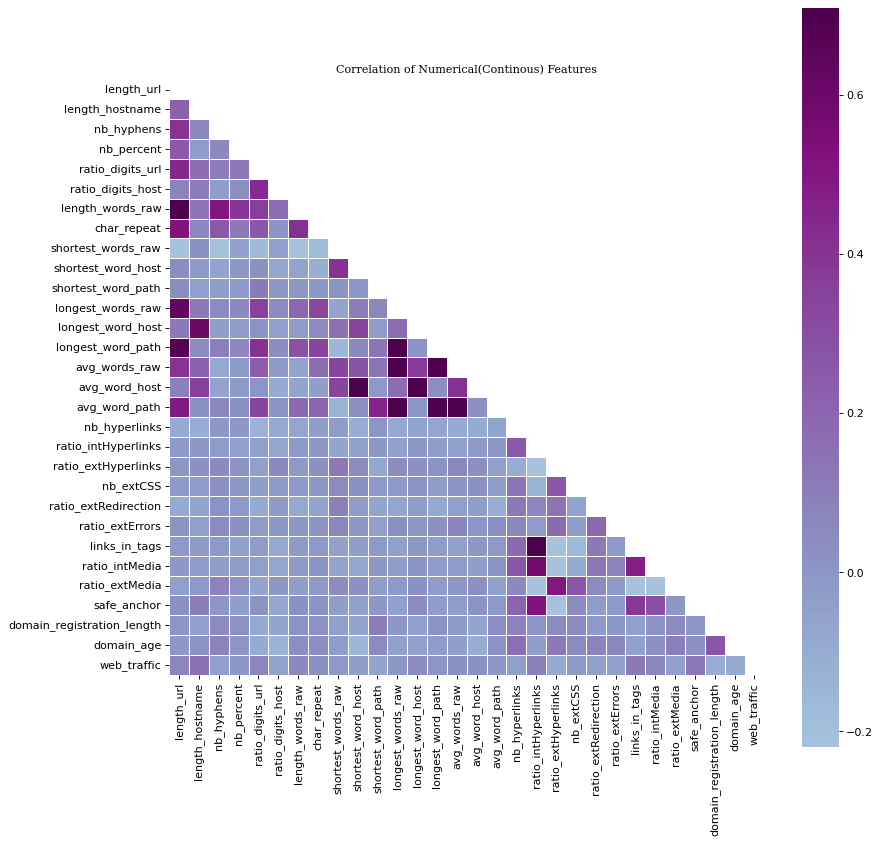

In [ ]:
likely_cat = {}
for var in df_data.iloc[:,1:].columns:
    likely_cat[var] = 1.*df_data[var].nunique()/df_data[var].count() < 0.002

num_cols = []
cat_cols = []
for col in likely_cat.keys():
    if (likely_cat[col] == False):
        num_cols.append(col)
    else:
        cat_cols.append(col)

#Taking all columns except URL
corr = df_data[num_cols].corr()

fig = plt.figure(figsize=(12,12),dpi=80)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='BuPu', robust=True, center=0,
            square=True, linewidths=.5)
plt.title('Correlation of Numerical(Continous) Features', fontsize=15,font="Serif")
plt.show()

In [ ]:

# Preprocessing
df_data['target'] = pd.get_dummies(df_data['status'])['legitimate'].astype('int')
df_data.drop('status', axis=1, inplace=True)

X = df_data.iloc[:, 1:-1]
y = df_data['target']


train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the number of samples used for training and testing
print(f"Total samples: {len(X)}")
print(f"Number of training samples: {len(train_x)}")
print(f"Number of testing samples: {len(test_x)}")

# Count the occurrences of each type in the training set
train_legitimate_count = train_y.value_counts().get(1, 0)
train_phishing_count = train_y.value_counts().get(0, 0)

# Count the occurrences of each type in the testing set
test_legitimate_count = test_y.value_counts().get(1, 0)
test_phishing_count = test_y.value_counts().get(0, 0)

print(f"Training set: Number of legitimate types: {train_legitimate_count}")
print(f"Training set: Number of phishing types: {train_phishing_count}")
print(f"Testing set: Number of legitimate types: {test_legitimate_count}")
print(f"Testing set: Number of phishing types: {test_phishing_count}")

# Scaling
scaler = MinMaxScaler()
x_train = scaler.fit_transform(train_x.values)
x_test = scaler.transform(test_x.values)  # Corrected this line

# Convert data to Tensors
x_train_rnn = x_train.reshape(-1, 1, x_train.shape[1])
x_test_rnn = x_test.reshape(-1, 1, x_test.shape[1])

x_train_tensor = torch.from_numpy(x_train_rnn).float()
y_train_tensor = torch.from_numpy(train_y.values.reshape(-1, 1)).float()
x_test_tensor = torch.from_numpy(x_test_rnn).float()
y_test_tensor = torch.from_numpy(test_y.values.reshape(-1, 1)).float()

batch_size = 128
train_ds_rnn = TensorDataset(x_train_tensor, y_train_tensor)
train_dl_rnn = DataLoader(train_ds_rnn, batch_size=batch_size, shuffle=True)
test_ds_rnn = TensorDataset(x_test_tensor, y_test_tensor)
test_dl_rnn = DataLoader(test_ds_rnn, batch_size=batch_size, shuffle=False)

# GRU with Attention Model

class PhishdetModelGRUAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PhishdetModelGRUAttention, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(2 * hidden_dim, 1)
        self.fc = nn.Linear(2 * hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.gru(x)
        attn_weights = torch.tanh(self.attention(out))
        attn_weights = F.softmax(attn_weights, dim=1)
        attn_out = torch.sum(attn_weights * out, dim=1)
        out = self.fc(attn_out)
        out = self.sigmoid(out)
        return out

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = x_train_rnn.shape[2]
hidden_dim = 128
output_dim = 1
model_gru_attention = PhishdetModelGRUAttention(input_dim, hidden_dim, output_dim).to(device)

Total samples: 11430
Number of training samples: 9144
Number of testing samples: 2286
Training set: Number of legitimate types: 4558
Training set: Number of phishing types: 4586
Testing set: Number of legitimate types: 1157
Testing set: Number of phishing types: 1129


Epoch [1/200], Train Loss: 0.0985, Validation Loss: 3.3679
Epoch [2/200], Train Loss: 0.2531, Validation Loss: 2.7606
Epoch [3/200], Train Loss: 0.2221, Validation Loss: 2.5533
Epoch [4/200], Train Loss: 0.1018, Validation Loss: 2.5947
Epoch [5/200], Train Loss: 0.1943, Validation Loss: 2.3701
Epoch [6/200], Train Loss: 0.2471, Validation Loss: 2.3234
Epoch [7/200], Train Loss: 0.2717, Validation Loss: 2.4083
Epoch [8/200], Train Loss: 0.1908, Validation Loss: 2.2381
Epoch [9/200], Train Loss: 0.2099, Validation Loss: 2.3050
Epoch [10/200], Train Loss: 0.0830, Validation Loss: 2.2125
Epoch [11/200], Train Loss: 0.1726, Validation Loss: 2.1964
Epoch [12/200], Train Loss: 0.2531, Validation Loss: 2.1550
Epoch [13/200], Train Loss: 0.0935, Validation Loss: 2.1012
Epoch [14/200], Train Loss: 0.0812, Validation Loss: 2.0757
Epoch [15/200], Train Loss: 0.1036, Validation Loss: 2.2445
Epoch [16/200], Train Loss: 0.2050, Validation Loss: 1.9956
Epoch [17/200], Train Loss: 0.0494, Validation Lo

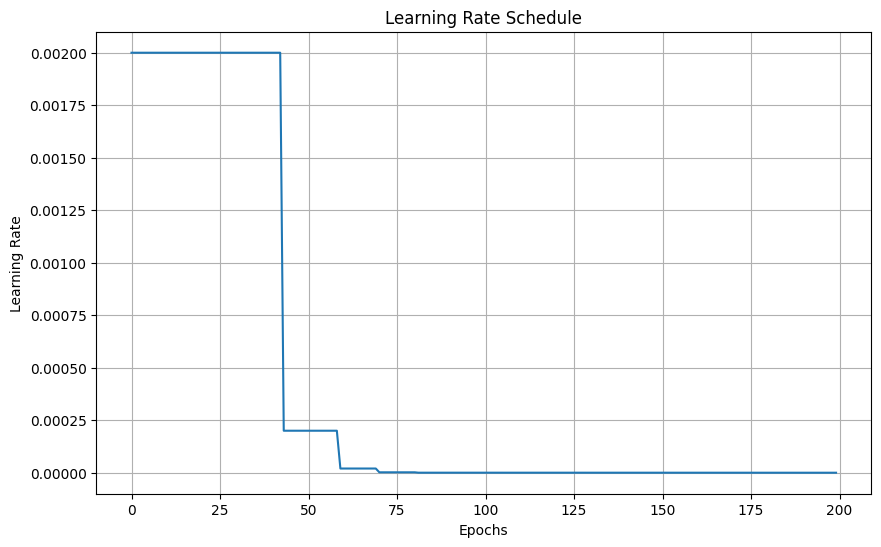

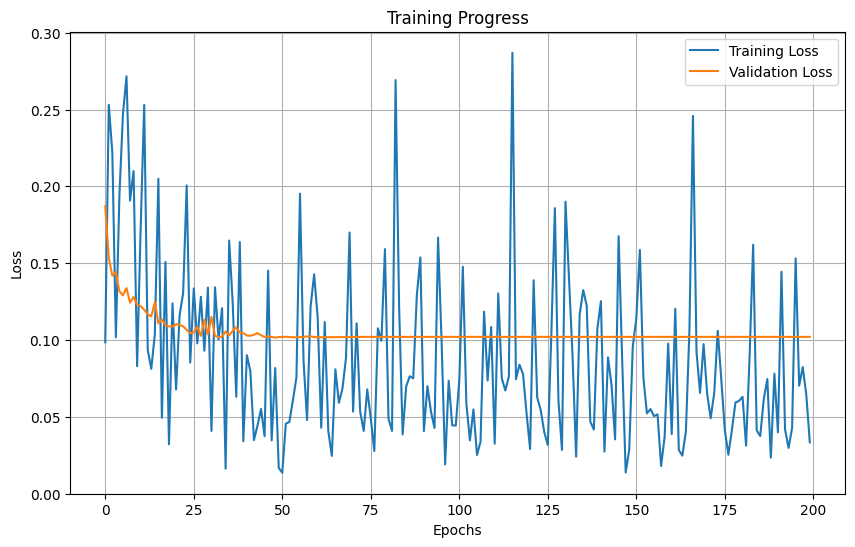

Accuracy: 0.9685
Precision: 0.9665
Recall: 0.9715
F1 Score: 0.9690


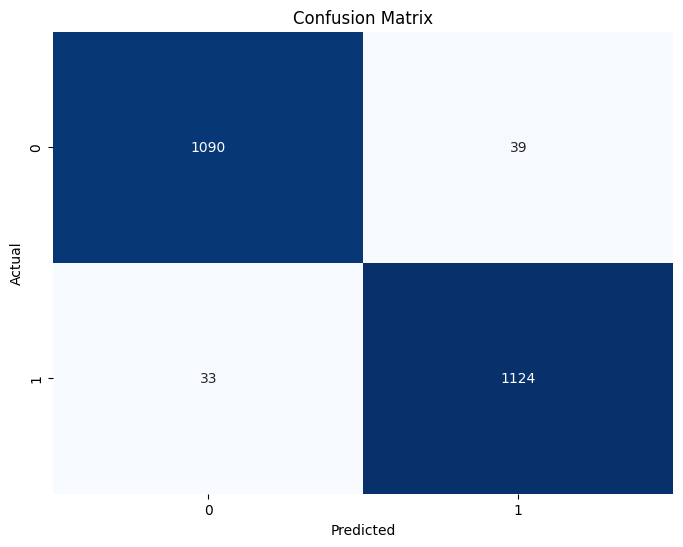

In [ ]:
# Loss, Optimizer, Scheduler
loss_func = nn.BCELoss()
learning_rate = 0.002
optimizer = torch.optim.Adam(model_gru_attention.parameters(), lr=learning_rate)  # Change here
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

epochs = 200
lr_values = []
val_losses = []
train_loss = []

# Training Loop
model_gru_attention.train()  # Change here
for epoch in range(epochs):
    for xb, yb in train_dl_rnn:
        xb, yb = xb.to(device), yb.to(device)
        y_pred = model_gru_attention(xb)  # Change here
        loss = loss_func(y_pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    val_loss = 0.0
    model_gru_attention.eval()  # Change here
    with torch.no_grad():
        for xb_val, yb_val in test_dl_rnn:
            xb_val, yb_val = xb_val.to(device), yb_val.to(device)
            y_val_pred = model_gru_attention(xb_val)  # Change here
            val_loss += loss_func(y_val_pred, yb_val).item()
    model_gru_attention.train()  # Change here

    # Update learning rate & log values
    scheduler.step(val_loss)
    lr_values.append(optimizer.param_groups[0]['lr'])
    val_losses.append(val_loss / len(test_dl_rnn))
    train_loss.append(loss.item())
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(lr_values)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()

# Model Evaluation

model_gru_attention.eval()  # Change here
all_preds = []
all_targets = []

with torch.no_grad():
    for xb_val, yb_val in test_dl_rnn:
        xb_val, yb_val = xb_val.to(device), yb_val.to(device)
        y_val_pred = model_gru_attention(xb_val)  # Change here
        preds = (y_val_pred > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(yb_val.cpu().numpy())

# Flatten lists for metrics computation
all_preds = [item for sublist in all_preds for item in sublist]
all_targets = [item for sublist in all_targets for item in sublist]

# Performance Metrics
accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds)
recall = recall_score(all_targets, all_preds)
f1score = f1_score(all_targets, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1score:.4f}")

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
class PhishdetModelGRUAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PhishdetModelGRUAttention, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(2 * hidden_dim, 1)
        self.fc = nn.Linear(2 * hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.gru(x)
        attn_weights = torch.tanh(self.attention(out))
        attn_weights = F.softmax(attn_weights, dim=1)
        attn_out = torch.sum(attn_weights * out, dim=1)
        out = self.fc(attn_out)
        out = self.sigmoid(out)
        return out

# Instantiate the model
input_dim = df_data.shape[1] - 1
hidden_dim = 128  # Assume hidden dimension is 128
output_dim = 1  # Assume output dimension is 1 (binary classification)
model_gru_attention = PhishdetModelGRUAttention(input_dim, hidden_dim, output_dim)

# Access hidden layer dimensions
hidden_layer_dimensions = hidden_dim
print("Hidden Layer Dimensions:", hidden_layer_dimensions)


Hidden Layer Dimensions: 128


In [ ]:
# Assuming conf_matrix is the confusion matrix obtained from the model evaluation
conf_matrix = confusion_matrix(all_targets, all_preds)

# Extract TP, TN, FP, FN values
tp = conf_matrix[1, 1]  # True Positive
tn = conf_matrix[0, 0]  # True Negative
fp = conf_matrix[0, 1]  # False Positive
fn = conf_matrix[1, 0]  # False Negative

# Print values
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")


True Positives (TP): 1124
True Negatives (TN): 1090
False Positives (FP): 39
False Negatives (FN): 33


In [ ]:
from sklearn.metrics import roc_curve, auc

# Assuming you have trained a model named 'model' and have test data

# Get predicted probabilities for positive class
y_scores = model(xtest_tensor).detach().numpy()

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(ytest_tensor, y_scores)

# Compute Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Add diagonal line for random guessing
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

NameError: ignored